# Project Background and Objectives

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.


#### Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

Loading and reading the dataset

In [4]:
data = pd.read_csv('/Users/rsavy/Downloads/taxi.csv',parse_dates=['datetime'], index_col='datetime')
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

**Checking if the data is in Chronological Order**

In [6]:
data.sort_index(inplace=True)
print(data.index.is_monotonic)

True


The data is in Chronological Order

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


We have 26496 rows of data...We have num of orders from 2018 March 1st to 2018 August 31st. So we have 6 months worth of data.

<AxesSubplot:xlabel='datetime'>

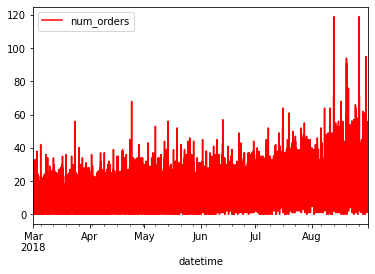

In [9]:
data.plot(color='r')

**Checking if data is stationary or non-stationary**

In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

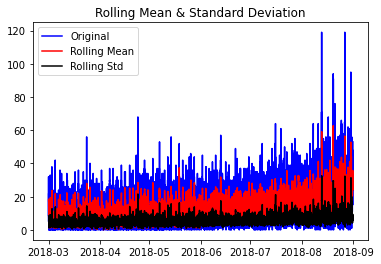

In [11]:
test_stationarity(data)

There is a trend in the data, therefore data is non-stationary.

**Resampling the data--Changing the Interval by 1 Hour**

In [12]:
dataset=data.resample('1H').sum()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


There are now 4416 rows after resampling by 1H

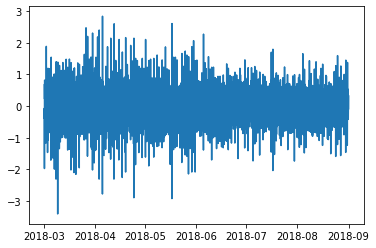

In [13]:
ts_log = np.log(dataset)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

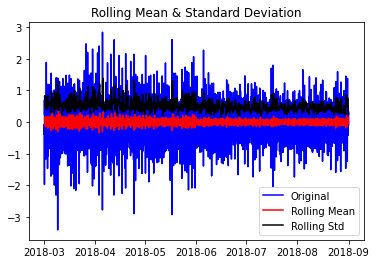

In [14]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Text(0.5, 1.0, 'Residuals')

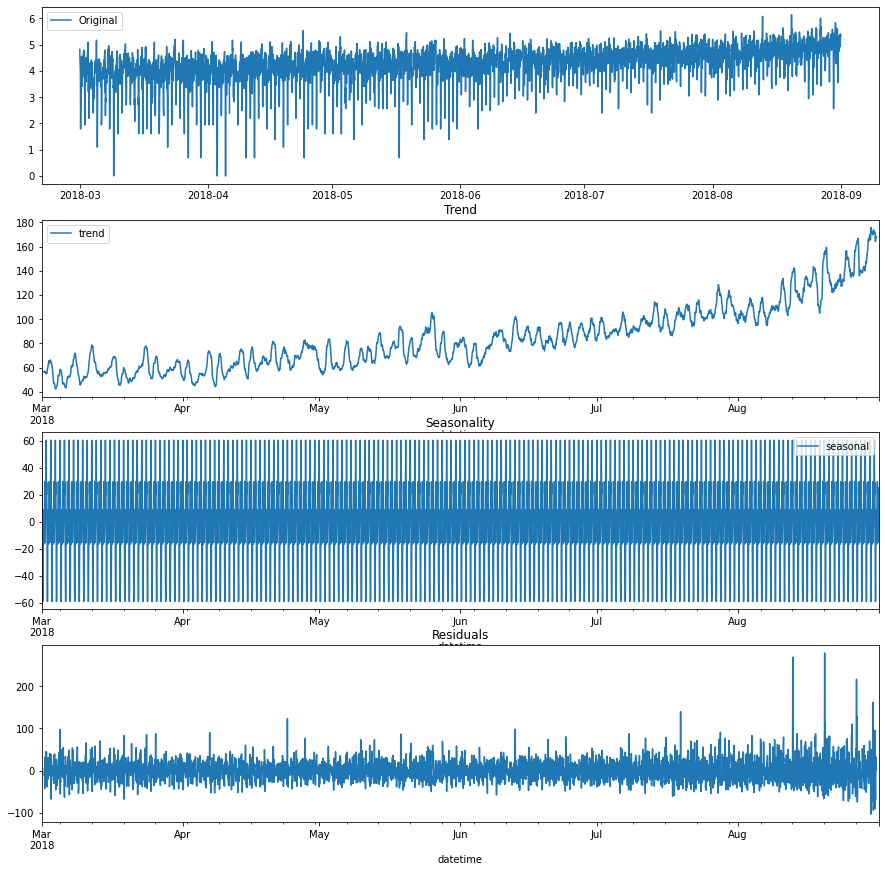

In [15]:
decomposed = seasonal_decompose(dataset)
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid
plt.figure(figsize=(15, 15))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.legend(loc='best')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.legend(loc='best')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

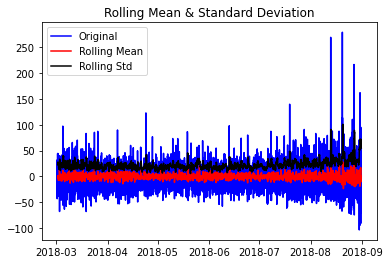

In [16]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Creating Features

In [17]:
def make_features(dataset, max_lag, rolling_mean_size):
    dataset['year'] = dataset.index.year
    dataset['month'] = dataset.index.month
    dataset['day'] = dataset.index.day
    dataset['dayofweek'] = dataset.index.dayofweek

    for lag in range(1, max_lag + 1):
        dataset['lag_{}'.format(lag)] = dataset["num_orders"].shift(lag)

    dataset['rolling_mean'] = (
        dataset["num_orders"].shift().rolling(rolling_mean_size).mean()
    )
    return dataset

In [18]:
dataset = make_features(dataset, 6, 8)

In [19]:
dataset

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,167.375
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,163.500
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,165.750


## Model Training

In [22]:
train, rest = train_test_split(dataset, shuffle=True, test_size=0.2, random_state=12345)
valid, test = train_test_split(rest, shuffle=False, test_size=0.5, random_state=12345)

train = train.dropna()
valid = valid.dropna()
test = test.dropna()

In [23]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
for estimator in range(150,200):
    RF = RandomForestRegressor(random_state=12345, n_estimators=estimator) 
   
    RF.fit(features_train, target_train)
    pred_train1 = RF.predict(features_valid)
    RMSE =  math.sqrt(mean_squared_error(target_valid, pred_train1)) 
    print("estimator =", estimator, "RMSE: ",RMSE)

estimator = 150 RMSE:  33.695571244127535
estimator = 151 RMSE:  33.69057358125316
estimator = 152 RMSE:  33.680480192306035
estimator = 153 RMSE:  33.69318748485129
estimator = 154 RMSE:  33.70578969593633
estimator = 155 RMSE:  33.71081577060223
estimator = 156 RMSE:  33.68751044454944
estimator = 157 RMSE:  33.67987995473357
estimator = 158 RMSE:  33.68995664177363
estimator = 159 RMSE:  33.68154320646006
estimator = 160 RMSE:  33.688455724507364
estimator = 161 RMSE:  33.688026280170405
estimator = 162 RMSE:  33.67914802208117
estimator = 163 RMSE:  33.681207029645634
estimator = 164 RMSE:  33.66289923866725
estimator = 165 RMSE:  33.64800466114685
estimator = 166 RMSE:  33.67348212531013
estimator = 167 RMSE:  33.64744484509961
estimator = 168 RMSE:  33.64934128924922
estimator = 169 RMSE:  33.668313400613854
estimator = 170 RMSE:  33.6527187464458
estimator = 171 RMSE:  33.64412639248385
estimator = 172 RMSE:  33.65193887518879
estimator = 173 RMSE:  33.62163195172277
estimator =

### Desicion Tree

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
for depth in range(10,30):
    regr_2 = DecisionTreeRegressor(max_depth=20).fit(features_train, target_train)
    pred_train2 = regr_2.predict(features_valid)
    RMSE1 =  math.sqrt(mean_squared_error(target_valid, pred_train2)) 
    print("Depth =", depth, "RMSE: ",RMSE)

Depth = 10 RMSE:  33.58335054202452
Depth = 11 RMSE:  33.58335054202452
Depth = 12 RMSE:  33.58335054202452
Depth = 13 RMSE:  33.58335054202452
Depth = 14 RMSE:  33.58335054202452
Depth = 15 RMSE:  33.58335054202452
Depth = 16 RMSE:  33.58335054202452
Depth = 17 RMSE:  33.58335054202452
Depth = 18 RMSE:  33.58335054202452
Depth = 19 RMSE:  33.58335054202452
Depth = 20 RMSE:  33.58335054202452
Depth = 21 RMSE:  33.58335054202452
Depth = 22 RMSE:  33.58335054202452
Depth = 23 RMSE:  33.58335054202452
Depth = 24 RMSE:  33.58335054202452
Depth = 25 RMSE:  33.58335054202452
Depth = 26 RMSE:  33.58335054202452
Depth = 27 RMSE:  33.58335054202452
Depth = 28 RMSE:  33.58335054202452
Depth = 29 RMSE:  33.58335054202452


### LightGBM 

In [30]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 20,
    "n_estimators": 100000
}

In [32]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [33]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(features_train, target_train,
        eval_set=[(features_valid, target_valid)],
        eval_metric='rmse',
        early_stopping_rounds=1000)


C:\Users\rsavy\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col

[149]	valid_0's rmse: 39.5946	valid_0's l1: 29.3528	valid_0's l2: 1567.73
[150]	valid_0's rmse: 39.5538	valid_0's l1: 29.3285	valid_0's l2: 1564.5
[151]	valid_0's rmse: 39.515	valid_0's l1: 29.3027	valid_0's l2: 1561.44
[152]	valid_0's rmse: 39.4841	valid_0's l1: 29.281	valid_0's l2: 1559
[153]	valid_0's rmse: 39.4436	valid_0's l1: 29.2547	valid_0's l2: 1555.8
[154]	valid_0's rmse: 39.4067	valid_0's l1: 29.2299	valid_0's l2: 1552.89
[155]	valid_0's rmse: 39.3686	valid_0's l1: 29.2048	valid_0's l2: 1549.89
[156]	valid_0's rmse: 39.3325	valid_0's l1: 29.1799	valid_0's l2: 1547.05
[157]	valid_0's rmse: 39.2944	valid_0's l1: 29.1548	valid_0's l2: 1544.05
[158]	valid_0's rmse: 39.2571	valid_0's l1: 29.1311	valid_0's l2: 1541.12
[159]	valid_0's rmse: 39.2213	valid_0's l1: 29.1084	valid_0's l2: 1538.31
[160]	valid_0's rmse: 39.1924	valid_0's l1: 29.0875	valid_0's l2: 1536.04
[161]	valid_0's rmse: 39.1601	valid_0's l1: 29.0621	valid_0's l2: 1533.51
[162]	valid_0's rmse: 39.1213	valid_0's l1: 2

[326]	valid_0's rmse: 36.1182	valid_0's l1: 26.7568	valid_0's l2: 1304.53
[327]	valid_0's rmse: 36.1063	valid_0's l1: 26.7468	valid_0's l2: 1303.67
[328]	valid_0's rmse: 36.1008	valid_0's l1: 26.7439	valid_0's l2: 1303.26
[329]	valid_0's rmse: 36.09	valid_0's l1: 26.7389	valid_0's l2: 1302.49
[330]	valid_0's rmse: 36.0793	valid_0's l1: 26.7338	valid_0's l2: 1301.72
[331]	valid_0's rmse: 36.0684	valid_0's l1: 26.7245	valid_0's l2: 1300.93
[332]	valid_0's rmse: 36.0589	valid_0's l1: 26.718	valid_0's l2: 1300.24
[333]	valid_0's rmse: 36.0487	valid_0's l1: 26.711	valid_0's l2: 1299.51
[334]	valid_0's rmse: 36.0423	valid_0's l1: 26.7031	valid_0's l2: 1299.05
[335]	valid_0's rmse: 36.0359	valid_0's l1: 26.6973	valid_0's l2: 1298.58
[336]	valid_0's rmse: 36.0271	valid_0's l1: 26.6925	valid_0's l2: 1297.95
[337]	valid_0's rmse: 36.0199	valid_0's l1: 26.6879	valid_0's l2: 1297.44
[338]	valid_0's rmse: 36.009	valid_0's l1: 26.6807	valid_0's l2: 1296.65
[339]	valid_0's rmse: 35.9983	valid_0's l1:

[503]	valid_0's rmse: 34.9593	valid_0's l1: 25.8887	valid_0's l2: 1222.15
[504]	valid_0's rmse: 34.9532	valid_0's l1: 25.8854	valid_0's l2: 1221.73
[505]	valid_0's rmse: 34.9515	valid_0's l1: 25.885	valid_0's l2: 1221.61
[506]	valid_0's rmse: 34.9477	valid_0's l1: 25.8848	valid_0's l2: 1221.34
[507]	valid_0's rmse: 34.9457	valid_0's l1: 25.8831	valid_0's l2: 1221.2
[508]	valid_0's rmse: 34.9427	valid_0's l1: 25.8819	valid_0's l2: 1220.99
[509]	valid_0's rmse: 34.9389	valid_0's l1: 25.8819	valid_0's l2: 1220.73
[510]	valid_0's rmse: 34.9387	valid_0's l1: 25.8812	valid_0's l2: 1220.71
[511]	valid_0's rmse: 34.9364	valid_0's l1: 25.8802	valid_0's l2: 1220.55
[512]	valid_0's rmse: 34.9338	valid_0's l1: 25.8782	valid_0's l2: 1220.37
[513]	valid_0's rmse: 34.9318	valid_0's l1: 25.8755	valid_0's l2: 1220.23
[514]	valid_0's rmse: 34.9294	valid_0's l1: 25.8749	valid_0's l2: 1220.06
[515]	valid_0's rmse: 34.9252	valid_0's l1: 25.8715	valid_0's l2: 1219.77
[516]	valid_0's rmse: 34.9235	valid_0's 

[685]	valid_0's rmse: 34.5368	valid_0's l1: 25.5712	valid_0's l2: 1192.79
[686]	valid_0's rmse: 34.5338	valid_0's l1: 25.5681	valid_0's l2: 1192.59
[687]	valid_0's rmse: 34.5352	valid_0's l1: 25.5665	valid_0's l2: 1192.68
[688]	valid_0's rmse: 34.5326	valid_0's l1: 25.5633	valid_0's l2: 1192.5
[689]	valid_0's rmse: 34.5327	valid_0's l1: 25.562	valid_0's l2: 1192.51
[690]	valid_0's rmse: 34.5295	valid_0's l1: 25.5591	valid_0's l2: 1192.29
[691]	valid_0's rmse: 34.5304	valid_0's l1: 25.5584	valid_0's l2: 1192.35
[692]	valid_0's rmse: 34.5319	valid_0's l1: 25.5584	valid_0's l2: 1192.45
[693]	valid_0's rmse: 34.5302	valid_0's l1: 25.556	valid_0's l2: 1192.33
[694]	valid_0's rmse: 34.5295	valid_0's l1: 25.5529	valid_0's l2: 1192.29
[695]	valid_0's rmse: 34.5274	valid_0's l1: 25.5513	valid_0's l2: 1192.14
[696]	valid_0's rmse: 34.5266	valid_0's l1: 25.5504	valid_0's l2: 1192.09
[697]	valid_0's rmse: 34.5256	valid_0's l1: 25.548	valid_0's l2: 1192.02
[698]	valid_0's rmse: 34.5209	valid_0's l1

[855]	valid_0's rmse: 34.1695	valid_0's l1: 25.2615	valid_0's l2: 1167.55
[856]	valid_0's rmse: 34.1642	valid_0's l1: 25.2592	valid_0's l2: 1167.19
[857]	valid_0's rmse: 34.159	valid_0's l1: 25.2563	valid_0's l2: 1166.84
[858]	valid_0's rmse: 34.1563	valid_0's l1: 25.2552	valid_0's l2: 1166.66
[859]	valid_0's rmse: 34.1519	valid_0's l1: 25.2531	valid_0's l2: 1166.35
[860]	valid_0's rmse: 34.1478	valid_0's l1: 25.2505	valid_0's l2: 1166.08
[861]	valid_0's rmse: 34.1483	valid_0's l1: 25.2508	valid_0's l2: 1166.11
[862]	valid_0's rmse: 34.1484	valid_0's l1: 25.2493	valid_0's l2: 1166.11
[863]	valid_0's rmse: 34.1504	valid_0's l1: 25.2498	valid_0's l2: 1166.25
[864]	valid_0's rmse: 34.152	valid_0's l1: 25.2493	valid_0's l2: 1166.36
[865]	valid_0's rmse: 34.1543	valid_0's l1: 25.2502	valid_0's l2: 1166.52
[866]	valid_0's rmse: 34.1563	valid_0's l1: 25.2493	valid_0's l2: 1166.65
[867]	valid_0's rmse: 34.1579	valid_0's l1: 25.2488	valid_0's l2: 1166.76
[868]	valid_0's rmse: 34.1607	valid_0's 

[1021]	valid_0's rmse: 34.0524	valid_0's l1: 25.1466	valid_0's l2: 1159.57
[1022]	valid_0's rmse: 34.0546	valid_0's l1: 25.1471	valid_0's l2: 1159.72
[1023]	valid_0's rmse: 34.0569	valid_0's l1: 25.1474	valid_0's l2: 1159.87
[1024]	valid_0's rmse: 34.059	valid_0's l1: 25.1473	valid_0's l2: 1160.02
[1025]	valid_0's rmse: 34.0624	valid_0's l1: 25.1492	valid_0's l2: 1160.24
[1026]	valid_0's rmse: 34.0661	valid_0's l1: 25.1506	valid_0's l2: 1160.5
[1027]	valid_0's rmse: 34.068	valid_0's l1: 25.15	valid_0's l2: 1160.63
[1028]	valid_0's rmse: 34.0695	valid_0's l1: 25.1495	valid_0's l2: 1160.73
[1029]	valid_0's rmse: 34.0685	valid_0's l1: 25.1485	valid_0's l2: 1160.66
[1030]	valid_0's rmse: 34.0706	valid_0's l1: 25.1506	valid_0's l2: 1160.81
[1031]	valid_0's rmse: 34.0725	valid_0's l1: 25.1522	valid_0's l2: 1160.93
[1032]	valid_0's rmse: 34.0744	valid_0's l1: 25.1529	valid_0's l2: 1161.06
[1033]	valid_0's rmse: 34.0742	valid_0's l1: 25.1523	valid_0's l2: 1161.05
[1034]	valid_0's rmse: 34.0762

[1183]	valid_0's rmse: 33.9696	valid_0's l1: 25.0415	valid_0's l2: 1153.93
[1184]	valid_0's rmse: 33.9725	valid_0's l1: 25.0433	valid_0's l2: 1154.13
[1185]	valid_0's rmse: 33.971	valid_0's l1: 25.0418	valid_0's l2: 1154.03
[1186]	valid_0's rmse: 33.9705	valid_0's l1: 25.0412	valid_0's l2: 1153.99
[1187]	valid_0's rmse: 33.9728	valid_0's l1: 25.0416	valid_0's l2: 1154.15
[1188]	valid_0's rmse: 33.9758	valid_0's l1: 25.0433	valid_0's l2: 1154.36
[1189]	valid_0's rmse: 33.9768	valid_0's l1: 25.0438	valid_0's l2: 1154.42
[1190]	valid_0's rmse: 33.9798	valid_0's l1: 25.0455	valid_0's l2: 1154.63
[1191]	valid_0's rmse: 33.9782	valid_0's l1: 25.0439	valid_0's l2: 1154.52
[1192]	valid_0's rmse: 33.978	valid_0's l1: 25.0424	valid_0's l2: 1154.51
[1193]	valid_0's rmse: 33.9772	valid_0's l1: 25.0405	valid_0's l2: 1154.45
[1194]	valid_0's rmse: 33.9782	valid_0's l1: 25.0402	valid_0's l2: 1154.52
[1195]	valid_0's rmse: 33.9775	valid_0's l1: 25.0385	valid_0's l2: 1154.47
[1196]	valid_0's rmse: 33.9

[1350]	valid_0's rmse: 33.9273	valid_0's l1: 24.9867	valid_0's l2: 1151.06
[1351]	valid_0's rmse: 33.9259	valid_0's l1: 24.9855	valid_0's l2: 1150.97
[1352]	valid_0's rmse: 33.9241	valid_0's l1: 24.9842	valid_0's l2: 1150.84
[1353]	valid_0's rmse: 33.9237	valid_0's l1: 24.9834	valid_0's l2: 1150.82
[1354]	valid_0's rmse: 33.9229	valid_0's l1: 24.9812	valid_0's l2: 1150.77
[1355]	valid_0's rmse: 33.9222	valid_0's l1: 24.9811	valid_0's l2: 1150.72
[1356]	valid_0's rmse: 33.922	valid_0's l1: 24.9814	valid_0's l2: 1150.7
[1357]	valid_0's rmse: 33.9215	valid_0's l1: 24.9807	valid_0's l2: 1150.67
[1358]	valid_0's rmse: 33.9217	valid_0's l1: 24.9818	valid_0's l2: 1150.68
[1359]	valid_0's rmse: 33.9212	valid_0's l1: 24.9833	valid_0's l2: 1150.65
[1360]	valid_0's rmse: 33.9202	valid_0's l1: 24.983	valid_0's l2: 1150.58
[1361]	valid_0's rmse: 33.9203	valid_0's l1: 24.983	valid_0's l2: 1150.58
[1362]	valid_0's rmse: 33.9249	valid_0's l1: 24.9854	valid_0's l2: 1150.9
[1363]	valid_0's rmse: 33.93	v

[1523]	valid_0's rmse: 33.9334	valid_0's l1: 24.9788	valid_0's l2: 1151.48
[1524]	valid_0's rmse: 33.9323	valid_0's l1: 24.9777	valid_0's l2: 1151.4
[1525]	valid_0's rmse: 33.9313	valid_0's l1: 24.9778	valid_0's l2: 1151.33
[1526]	valid_0's rmse: 33.9282	valid_0's l1: 24.9775	valid_0's l2: 1151.12
[1527]	valid_0's rmse: 33.9237	valid_0's l1: 24.9754	valid_0's l2: 1150.82
[1528]	valid_0's rmse: 33.9232	valid_0's l1: 24.9765	valid_0's l2: 1150.78
[1529]	valid_0's rmse: 33.9203	valid_0's l1: 24.9756	valid_0's l2: 1150.59
[1530]	valid_0's rmse: 33.9193	valid_0's l1: 24.9749	valid_0's l2: 1150.52
[1531]	valid_0's rmse: 33.9179	valid_0's l1: 24.9756	valid_0's l2: 1150.42
[1532]	valid_0's rmse: 33.9175	valid_0's l1: 24.9763	valid_0's l2: 1150.4
[1533]	valid_0's rmse: 33.9172	valid_0's l1: 24.9772	valid_0's l2: 1150.37
[1534]	valid_0's rmse: 33.9163	valid_0's l1: 24.9782	valid_0's l2: 1150.32
[1535]	valid_0's rmse: 33.9151	valid_0's l1: 24.9792	valid_0's l2: 1150.23
[1536]	valid_0's rmse: 33.9

[1690]	valid_0's rmse: 33.9035	valid_0's l1: 24.9579	valid_0's l2: 1149.45
[1691]	valid_0's rmse: 33.9019	valid_0's l1: 24.9573	valid_0's l2: 1149.34
[1692]	valid_0's rmse: 33.898	valid_0's l1: 24.9542	valid_0's l2: 1149.08
[1693]	valid_0's rmse: 33.8972	valid_0's l1: 24.954	valid_0's l2: 1149.02
[1694]	valid_0's rmse: 33.8958	valid_0's l1: 24.9519	valid_0's l2: 1148.93
[1695]	valid_0's rmse: 33.8974	valid_0's l1: 24.953	valid_0's l2: 1149.03
[1696]	valid_0's rmse: 33.8989	valid_0's l1: 24.9542	valid_0's l2: 1149.13
[1697]	valid_0's rmse: 33.8968	valid_0's l1: 24.9532	valid_0's l2: 1148.99
[1698]	valid_0's rmse: 33.897	valid_0's l1: 24.9538	valid_0's l2: 1149.01
[1699]	valid_0's rmse: 33.8933	valid_0's l1: 24.9507	valid_0's l2: 1148.76
[1700]	valid_0's rmse: 33.8961	valid_0's l1: 24.9537	valid_0's l2: 1148.94
[1701]	valid_0's rmse: 33.8944	valid_0's l1: 24.9514	valid_0's l2: 1148.83
[1702]	valid_0's rmse: 33.8938	valid_0's l1: 24.9513	valid_0's l2: 1148.79
[1703]	valid_0's rmse: 33.891

[1857]	valid_0's rmse: 33.949	valid_0's l1: 24.9517	valid_0's l2: 1152.53
[1858]	valid_0's rmse: 33.9466	valid_0's l1: 24.9488	valid_0's l2: 1152.37
[1859]	valid_0's rmse: 33.9453	valid_0's l1: 24.9483	valid_0's l2: 1152.28
[1860]	valid_0's rmse: 33.943	valid_0's l1: 24.9454	valid_0's l2: 1152.13
[1861]	valid_0's rmse: 33.9438	valid_0's l1: 24.9453	valid_0's l2: 1152.18
[1862]	valid_0's rmse: 33.9446	valid_0's l1: 24.9451	valid_0's l2: 1152.24
[1863]	valid_0's rmse: 33.9458	valid_0's l1: 24.9452	valid_0's l2: 1152.31
[1864]	valid_0's rmse: 33.9471	valid_0's l1: 24.9456	valid_0's l2: 1152.41
[1865]	valid_0's rmse: 33.9484	valid_0's l1: 24.946	valid_0's l2: 1152.49
[1866]	valid_0's rmse: 33.9497	valid_0's l1: 24.9467	valid_0's l2: 1152.58
[1867]	valid_0's rmse: 33.9505	valid_0's l1: 24.9482	valid_0's l2: 1152.63
[1868]	valid_0's rmse: 33.9524	valid_0's l1: 24.9489	valid_0's l2: 1152.76
[1869]	valid_0's rmse: 33.9536	valid_0's l1: 24.9493	valid_0's l2: 1152.85
[1870]	valid_0's rmse: 33.95

[2033]	valid_0's rmse: 33.9291	valid_0's l1: 24.954	valid_0's l2: 1151.18
[2034]	valid_0's rmse: 33.9317	valid_0's l1: 24.9551	valid_0's l2: 1151.36
[2035]	valid_0's rmse: 33.9344	valid_0's l1: 24.9577	valid_0's l2: 1151.54
[2036]	valid_0's rmse: 33.9365	valid_0's l1: 24.9579	valid_0's l2: 1151.69
[2037]	valid_0's rmse: 33.9392	valid_0's l1: 24.959	valid_0's l2: 1151.87
[2038]	valid_0's rmse: 33.9418	valid_0's l1: 24.9597	valid_0's l2: 1152.04
[2039]	valid_0's rmse: 33.943	valid_0's l1: 24.9597	valid_0's l2: 1152.13
[2040]	valid_0's rmse: 33.9454	valid_0's l1: 24.9623	valid_0's l2: 1152.29
[2041]	valid_0's rmse: 33.944	valid_0's l1: 24.9627	valid_0's l2: 1152.19
[2042]	valid_0's rmse: 33.9435	valid_0's l1: 24.9629	valid_0's l2: 1152.16
[2043]	valid_0's rmse: 33.9448	valid_0's l1: 24.9642	valid_0's l2: 1152.25
[2044]	valid_0's rmse: 33.9442	valid_0's l1: 24.964	valid_0's l2: 1152.21
[2045]	valid_0's rmse: 33.9436	valid_0's l1: 24.9638	valid_0's l2: 1152.17
[2046]	valid_0's rmse: 33.9426

[2210]	valid_0's rmse: 33.9204	valid_0's l1: 24.9661	valid_0's l2: 1150.59
[2211]	valid_0's rmse: 33.9203	valid_0's l1: 24.9651	valid_0's l2: 1150.59
[2212]	valid_0's rmse: 33.9171	valid_0's l1: 24.9638	valid_0's l2: 1150.37
[2213]	valid_0's rmse: 33.9172	valid_0's l1: 24.9629	valid_0's l2: 1150.38
[2214]	valid_0's rmse: 33.9173	valid_0's l1: 24.962	valid_0's l2: 1150.38
[2215]	valid_0's rmse: 33.916	valid_0's l1: 24.9611	valid_0's l2: 1150.3
[2216]	valid_0's rmse: 33.9145	valid_0's l1: 24.9601	valid_0's l2: 1150.2
[2217]	valid_0's rmse: 33.9124	valid_0's l1: 24.9579	valid_0's l2: 1150.05
[2218]	valid_0's rmse: 33.91	valid_0's l1: 24.9557	valid_0's l2: 1149.89
[2219]	valid_0's rmse: 33.9083	valid_0's l1: 24.9543	valid_0's l2: 1149.78
[2220]	valid_0's rmse: 33.9079	valid_0's l1: 24.9529	valid_0's l2: 1149.74
[2221]	valid_0's rmse: 33.9098	valid_0's l1: 24.9534	valid_0's l2: 1149.87
[2222]	valid_0's rmse: 33.9124	valid_0's l1: 24.9547	valid_0's l2: 1150.05
[2223]	valid_0's rmse: 33.913	v

[2369]	valid_0's rmse: 33.8506	valid_0's l1: 24.9131	valid_0's l2: 1145.86
[2370]	valid_0's rmse: 33.8496	valid_0's l1: 24.912	valid_0's l2: 1145.79
[2371]	valid_0's rmse: 33.8485	valid_0's l1: 24.9106	valid_0's l2: 1145.72
[2372]	valid_0's rmse: 33.8468	valid_0's l1: 24.9099	valid_0's l2: 1145.6
[2373]	valid_0's rmse: 33.8455	valid_0's l1: 24.9087	valid_0's l2: 1145.52
[2374]	valid_0's rmse: 33.8453	valid_0's l1: 24.9092	valid_0's l2: 1145.5
[2375]	valid_0's rmse: 33.8456	valid_0's l1: 24.9098	valid_0's l2: 1145.52
[2376]	valid_0's rmse: 33.8447	valid_0's l1: 24.9101	valid_0's l2: 1145.46
[2377]	valid_0's rmse: 33.8455	valid_0's l1: 24.9108	valid_0's l2: 1145.52
[2378]	valid_0's rmse: 33.8452	valid_0's l1: 24.9099	valid_0's l2: 1145.5
[2379]	valid_0's rmse: 33.8437	valid_0's l1: 24.9103	valid_0's l2: 1145.39
[2380]	valid_0's rmse: 33.845	valid_0's l1: 24.9105	valid_0's l2: 1145.48
[2381]	valid_0's rmse: 33.8455	valid_0's l1: 24.9115	valid_0's l2: 1145.52
[2382]	valid_0's rmse: 33.8448

[2543]	valid_0's rmse: 33.8667	valid_0's l1: 24.9105	valid_0's l2: 1146.95
[2544]	valid_0's rmse: 33.865	valid_0's l1: 24.9092	valid_0's l2: 1146.84
[2545]	valid_0's rmse: 33.8633	valid_0's l1: 24.9081	valid_0's l2: 1146.72
[2546]	valid_0's rmse: 33.8621	valid_0's l1: 24.9067	valid_0's l2: 1146.64
[2547]	valid_0's rmse: 33.8604	valid_0's l1: 24.9056	valid_0's l2: 1146.53
[2548]	valid_0's rmse: 33.8581	valid_0's l1: 24.904	valid_0's l2: 1146.37
[2549]	valid_0's rmse: 33.8571	valid_0's l1: 24.903	valid_0's l2: 1146.3
[2550]	valid_0's rmse: 33.8557	valid_0's l1: 24.9025	valid_0's l2: 1146.21
[2551]	valid_0's rmse: 33.8561	valid_0's l1: 24.9039	valid_0's l2: 1146.24
[2552]	valid_0's rmse: 33.8562	valid_0's l1: 24.9034	valid_0's l2: 1146.24
[2553]	valid_0's rmse: 33.8533	valid_0's l1: 24.9019	valid_0's l2: 1146.04
[2554]	valid_0's rmse: 33.8532	valid_0's l1: 24.9028	valid_0's l2: 1146.04
[2555]	valid_0's rmse: 33.8515	valid_0's l1: 24.9017	valid_0's l2: 1145.92
[2556]	valid_0's rmse: 33.850

[2709]	valid_0's rmse: 33.87	valid_0's l1: 24.9295	valid_0's l2: 1147.18
[2710]	valid_0's rmse: 33.8688	valid_0's l1: 24.9296	valid_0's l2: 1147.1
[2711]	valid_0's rmse: 33.8682	valid_0's l1: 24.9294	valid_0's l2: 1147.05
[2712]	valid_0's rmse: 33.8676	valid_0's l1: 24.9283	valid_0's l2: 1147.01
[2713]	valid_0's rmse: 33.8671	valid_0's l1: 24.9275	valid_0's l2: 1146.98
[2714]	valid_0's rmse: 33.8664	valid_0's l1: 24.9271	valid_0's l2: 1146.93
[2715]	valid_0's rmse: 33.865	valid_0's l1: 24.926	valid_0's l2: 1146.84
[2716]	valid_0's rmse: 33.866	valid_0's l1: 24.9265	valid_0's l2: 1146.9
[2717]	valid_0's rmse: 33.8659	valid_0's l1: 24.9268	valid_0's l2: 1146.9
[2718]	valid_0's rmse: 33.8661	valid_0's l1: 24.9273	valid_0's l2: 1146.91
[2719]	valid_0's rmse: 33.8661	valid_0's l1: 24.9276	valid_0's l2: 1146.91
[2720]	valid_0's rmse: 33.8655	valid_0's l1: 24.9268	valid_0's l2: 1146.87
[2721]	valid_0's rmse: 33.8673	valid_0's l1: 24.9284	valid_0's l2: 1147
[2722]	valid_0's rmse: 33.8689	valid

[2885]	valid_0's rmse: 33.8636	valid_0's l1: 24.9697	valid_0's l2: 1146.74
[2886]	valid_0's rmse: 33.8627	valid_0's l1: 24.9691	valid_0's l2: 1146.68
[2887]	valid_0's rmse: 33.8628	valid_0's l1: 24.9691	valid_0's l2: 1146.69
[2888]	valid_0's rmse: 33.8619	valid_0's l1: 24.9679	valid_0's l2: 1146.63
[2889]	valid_0's rmse: 33.8608	valid_0's l1: 24.9669	valid_0's l2: 1146.55
[2890]	valid_0's rmse: 33.8596	valid_0's l1: 24.966	valid_0's l2: 1146.47
[2891]	valid_0's rmse: 33.8604	valid_0's l1: 24.9675	valid_0's l2: 1146.53
[2892]	valid_0's rmse: 33.8621	valid_0's l1: 24.969	valid_0's l2: 1146.64
[2893]	valid_0's rmse: 33.8623	valid_0's l1: 24.9694	valid_0's l2: 1146.65
[2894]	valid_0's rmse: 33.8622	valid_0's l1: 24.9691	valid_0's l2: 1146.65
[2895]	valid_0's rmse: 33.8622	valid_0's l1: 24.9684	valid_0's l2: 1146.65
[2896]	valid_0's rmse: 33.8628	valid_0's l1: 24.9695	valid_0's l2: 1146.69
[2897]	valid_0's rmse: 33.8624	valid_0's l1: 24.9695	valid_0's l2: 1146.66
[2898]	valid_0's rmse: 33.8

[3062]	valid_0's rmse: 33.828	valid_0's l1: 24.9393	valid_0's l2: 1144.34
[3063]	valid_0's rmse: 33.8284	valid_0's l1: 24.9388	valid_0's l2: 1144.36
[3064]	valid_0's rmse: 33.8277	valid_0's l1: 24.9372	valid_0's l2: 1144.31
[3065]	valid_0's rmse: 33.8279	valid_0's l1: 24.9368	valid_0's l2: 1144.33
[3066]	valid_0's rmse: 33.8262	valid_0's l1: 24.9359	valid_0's l2: 1144.21
[3067]	valid_0's rmse: 33.8276	valid_0's l1: 24.9372	valid_0's l2: 1144.3
[3068]	valid_0's rmse: 33.829	valid_0's l1: 24.9375	valid_0's l2: 1144.4
[3069]	valid_0's rmse: 33.8292	valid_0's l1: 24.9372	valid_0's l2: 1144.42
[3070]	valid_0's rmse: 33.8306	valid_0's l1: 24.9373	valid_0's l2: 1144.51
[3071]	valid_0's rmse: 33.8322	valid_0's l1: 24.9378	valid_0's l2: 1144.62
[3072]	valid_0's rmse: 33.8339	valid_0's l1: 24.9382	valid_0's l2: 1144.73
[3073]	valid_0's rmse: 33.833	valid_0's l1: 24.9369	valid_0's l2: 1144.67
[3074]	valid_0's rmse: 33.8362	valid_0's l1: 24.9394	valid_0's l2: 1144.89
[3075]	valid_0's rmse: 33.839	

[3237]	valid_0's rmse: 33.8688	valid_0's l1: 24.9686	valid_0's l2: 1147.09
[3238]	valid_0's rmse: 33.8683	valid_0's l1: 24.9678	valid_0's l2: 1147.06
[3239]	valid_0's rmse: 33.8671	valid_0's l1: 24.9664	valid_0's l2: 1146.98
[3240]	valid_0's rmse: 33.8668	valid_0's l1: 24.9658	valid_0's l2: 1146.96
[3241]	valid_0's rmse: 33.8678	valid_0's l1: 24.9666	valid_0's l2: 1147.03
[3242]	valid_0's rmse: 33.8678	valid_0's l1: 24.9667	valid_0's l2: 1147.03
[3243]	valid_0's rmse: 33.8691	valid_0's l1: 24.9669	valid_0's l2: 1147.11
[3244]	valid_0's rmse: 33.8693	valid_0's l1: 24.9671	valid_0's l2: 1147.13
[3245]	valid_0's rmse: 33.8686	valid_0's l1: 24.9669	valid_0's l2: 1147.09
[3246]	valid_0's rmse: 33.8699	valid_0's l1: 24.9671	valid_0's l2: 1147.17
[3247]	valid_0's rmse: 33.8693	valid_0's l1: 24.9668	valid_0's l2: 1147.13
[3248]	valid_0's rmse: 33.8695	valid_0's l1: 24.9667	valid_0's l2: 1147.14
[3249]	valid_0's rmse: 33.8689	valid_0's l1: 24.9664	valid_0's l2: 1147.1
[3250]	valid_0's rmse: 33.

[3412]	valid_0's rmse: 33.8504	valid_0's l1: 24.9237	valid_0's l2: 1145.85
[3413]	valid_0's rmse: 33.8498	valid_0's l1: 24.9235	valid_0's l2: 1145.81
[3414]	valid_0's rmse: 33.8477	valid_0's l1: 24.9229	valid_0's l2: 1145.67
[3415]	valid_0's rmse: 33.8459	valid_0's l1: 24.922	valid_0's l2: 1145.55
[3416]	valid_0's rmse: 33.844	valid_0's l1: 24.9219	valid_0's l2: 1145.42
[3417]	valid_0's rmse: 33.8432	valid_0's l1: 24.9214	valid_0's l2: 1145.36
[3418]	valid_0's rmse: 33.8414	valid_0's l1: 24.9212	valid_0's l2: 1145.24
[3419]	valid_0's rmse: 33.8398	valid_0's l1: 24.921	valid_0's l2: 1145.13


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_depth=20, metric=['l1', 'l2'],
              n_estimators=100000, objective='rmse', task='train', verbose=0)

In [34]:
y_pred2 = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
mse2=mean_squared_error(target_test,y_pred2)
rmse2=np.sqrt(mse2)
print('The rmse of prediction is:',rmse2 )

The rmse of prediction is: 28.495976122885843


## Model Testing

Testing the models with Best Parameters tuned during training

#### Random Forest

In [35]:
RF1 = RandomForestRegressor(random_state=12345, n_estimators=162) .fit(features_valid, target_valid)
pred_test1 = RF1.predict(features_test)

print(
    'RMSE for the test set:', math.sqrt(mean_squared_error(target_test, pred_test1)))

RMSE for the test set: 34.168105638703565


#### Desion Tree

In [36]:
DT = DecisionTreeRegressor(random_state=12345, max_depth=20) .fit(features_valid, target_valid)
pred_test2 = DT.predict(features_test)

print(
    'RMSE for the test set:', math.sqrt(mean_squared_error(target_test, pred_test2)))

RMSE for the test set: 48.214695043957484


#### LightGBM 

In [37]:
y_pred2 = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
mse2=mean_squared_error(target_test,y_pred2)
rmse2=np.sqrt(mse2)
print('The rmse of prediction is:',rmse2 )

The rmse of prediction is: 28.495976122885843


Among all 3 models,Light GMB gave the lowest RMSE in the test set which is 28.59.

## Sanity Check

In [38]:
model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)
model.fit(features_train, target_train)

pred_train = model.predict(features_valid)


print(
    'RMSE for the training set:', math.sqrt(mean_squared_error(target_valid, pred_train)))

RMSE for the training set: 36.46751599701262


In [41]:
pred_tst = model.predict(features_test)


print(
    'RMSE for the test set:', math.sqrt(mean_squared_error(target_test, pred_tst)))

RMSE for the test set: 32.412519549189774


# Conclusion

Among the 4 different models, Light GMB gave the lowest RMSE score i.e. 28.59